# Desarollo Modelo HTM Proyecto de Grado

## 1. Importar Librerías y Archivos

### 1.1. Importar Librerías

In [1]:
# Misc
import os
import csv
import time
import math
import random
import datetime
import itertools
import numpy as np
import pandas as pd
from scipy import stats
from functools import partial
from multiprocessing import Pool

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# Mathplot
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap

In [3]:
# Sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
# HTM
from htm.bindings.sdr import SDR, Metrics
from htm.encoders.date import DateEncoder
from htm.algorithms.anomaly import Anomaly
from htm.bindings.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
from htm.encoders.rdse import RDSE, RDSE_Parameters
from htm.algorithms.anomaly_likelihood import AnomalyLikelihood
from htm.encoders.scalar_encoder import ScalarEncoder, ScalarEncoderParameters

/app/.venv/lib/python3.13/site-packages/htm/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


### 1.2. Importar Datos de Pacientes

In [5]:
studied_patients = []
studied_patients_ages = []
studied_patients_conditions = []

patient_dir = 'patient_data'

# Load patient data with the file name patient_<age>_<condition>.txt
for file_name in os.listdir(patient_dir):
        
        # Read each file
        file_path = os.path.join(patient_dir, file_name)
        data = pd.read_csv(file_path, sep='\t', skiprows=13, encoding='latin1')
        
        # Extract age and condition from the file name
        file_name_parts = file_name.split('_')
        age = int(file_name_parts[1])
        condition = file_name_parts[2].split('.')[0] 
        
        # Add the data to the lists
        studied_patients.append(data)
        studied_patients_ages.append(age)
        studied_patients_conditions.append(condition)      

## 2. Limpieza y Preparación de Datos

### 2.1. Parametros de los signos vitales a utilizar

In [6]:
# List of all vital signs collected by the monitor
all_vital_signs = ['FC', 'SpO2', 'IP', 'Resp', 'ARTs', 'ARTm', 'ARTd', 'T1', 'PI', '1s', '1m', '1d', 'T1']

# List of vitial signs of interest for this project
vital_signs = ['FC', 'SpO2', 'Resp', 'ARTs', 'ARTd']

In [7]:
id_paciente = 2

### 2.2. Ajustar etiqueta de tiempo y manejar valores nulos

In [8]:
def prepare_patient_data(patient):
    
    # Convert 'Timestamp' column to datetime
    patient['Time'] = pd.to_datetime(patient['Time'], format="%Y/%m/%d %H:%M:%S")
    
    # Convert available columns to numeric, setting errors='coerce' to handle '---'
    for col in all_vital_signs:
        if col in patient.columns:
            
            # Format all readings into numbers
            patient[col] = pd.to_numeric(patient[col], errors='coerce')
            
            # Replace [-1, 0, 1] values with NaN ([-1, 0, 1] are known error readings)
            patient[col] = patient[col].replace([-1, 0, 1], np.nan)

    # Drop any empty columns
    patient.dropna(how='all', axis=1, inplace=True)

    # Sort by timestamp in ascending order
    patient.sort_values(by='Time', inplace=True)

    # Set 'Timestamp' as the index for plotting
    patient.set_index('Time', inplace=True)
    
    # Drop any empty rows
    patient.dropna(axis = 0, how = 'all', inplace = True)
    
    # print the total time range of the patient data
    print(f"Patient data range: {patient.index.min()} to {patient.index.max()}")
    # get the total number of minutes in the patient data
    total_minutes = (patient.index.max() - patient.index.min()).total_seconds() / 60
    print(f"Total minutes of data: {total_minutes:.2f} minutes")   

In [9]:
# find out of the vital signs which ones are available in the patient data, and make that the studied vital signs
def get_studied_vital_signs(patient):
    available_vital_signs = []
    
    for col in vital_signs:
        if col in patient.columns:
            available_vital_signs.append(col)
    
    # If no vital signs are available, return an empty list
    if not available_vital_signs:
        return []
    
    # Return the available vital signs
    return available_vital_signs
    

### 2.3. Visualizar el los signos vitales de un paciente despues de la preparación

In [10]:
def visualize_patient_data(patient, patient_id):
    
    patient = patient.sort_index()  # Sort by index (timestamps)
    
    # Plot available variables
    plt.figure(figsize=(14, 6))
    for col in studied_vital_signs:
        if col in patient.columns:
            plt.plot(patient.index, patient[col], label=col, linewidth=1)
    
    # Customize the plot
    plt.title(f'Signos Vitales {patient_id}')
    plt.xlabel('Tiempo (HH:MM:SS)')
    plt.ylabel('Mediciones de Signos Vitales')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.grid(True)
    
    # Move legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))  # Adjusts to be outside
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leaves space for legend
    plt.show()

### 2.4. Aplicar la función de limpieza a todos los pacientes

Patient data range: 2025-04-20 21:25:00 to 2025-04-21 14:04:00
Total minutes of data: 999.00 minutes
Studied vital signs: ['FC', 'SpO2', 'Resp']


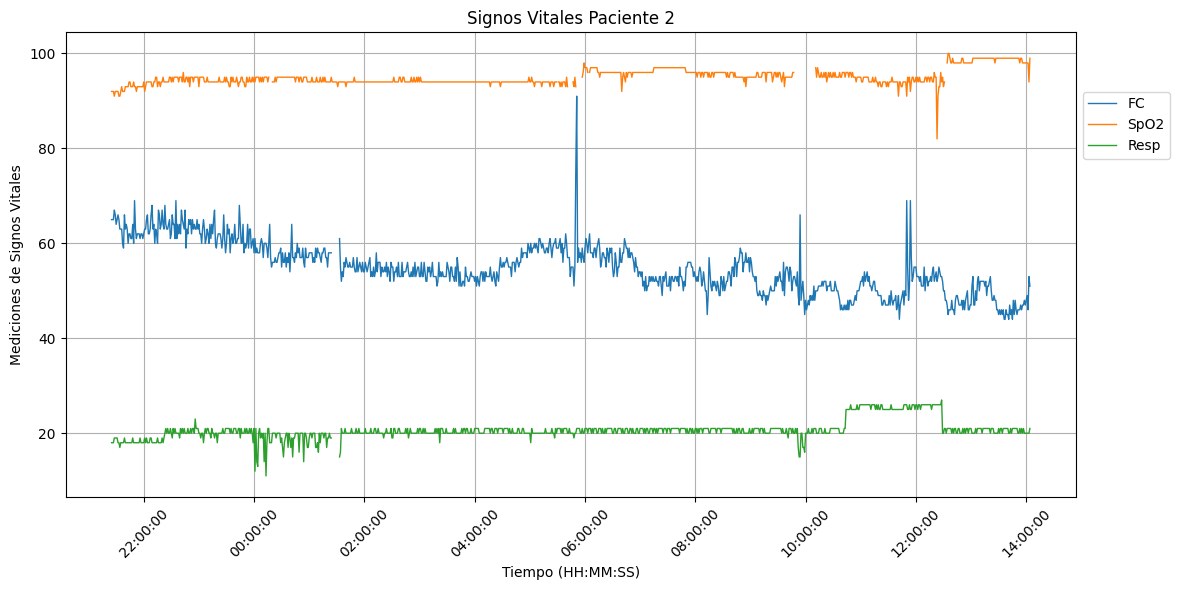

In [11]:
# Apply the preparation and visulize the vital signs for each patient
for patient_id, patient in enumerate(studied_patients):
    
    # Clean and prepare the data
    prepare_patient_data(patient)
    
    studied_vital_signs = get_studied_vital_signs(patient)
    print(f"Studied vital signs: {studied_vital_signs}")
    
    # Visualize the data
    visualize_patient_data(patient, f'Paciente {id_paciente}')  

## 3. Calcular anomalias de cada paciente

### 3.1 Calcular anomalias a partir de los valores normales

In [12]:
# Define normal ranges for vital signs based on age ranges
normal_ranges = {
    
    "ARTs": {
        "0-1 años": (60, 90),
        "2-2 años": (78, 112),  
        "3-8 años": (85, 114),  
        "9-12 años": (95, 135),  
        "13-18 años": (100, 120)
    },    
    "ARTd": {
        "0-1 años": (30, 62),  
        "2-2 años": (48, 78),  
        "3-8 años": (52, 85),  
        "9-12 años": (58, 88),  
        "13-18 años": (60, 80)
    },    
    "FC": {
        "0-1 años": (100, 160), 
        "1-3 años": (95, 150), 
        "4-5 años": (80, 140), 
        "6-12 años": (70, 120), 
        "13-18 años": (60, 100)
    },    
    "Resp": {
        "0-1 años": (30, 60), 
        "1-3 años": (24, 40), 
        "4-5 años": (22, 34), 
        "6-12 años": (18, 30), 
        "13-18 años": (12, 16)
    },    
    "SpO2": {
        "0-1 años": (88, 100), # SpO2 is the same for all ages
        "1-3 años": (88, 100),
        "4-5 años": (88, 100),
        "6-12 años": (88, 100),
        "13-18 años": (88, 100)
    },
}

In [13]:
# Function to map age to age range string for each vital sign
def get_age_range(age, col):
    if col in ["ARTs", "ARTd"]:
        if age <= 1:
            return "0-1 años"
        elif age == 2:
            return "2-2 años"
        elif 3 <= age <= 8:
            return "3-8 años"
        elif 9 <= age <= 12:
            return "9-12 años"
        else:
            return "13-18 años"
    elif col == "FC":
        if age <= 1:
            return "0-1 años"
        elif 1 < age <= 3:
            return "1-3 años"
        elif 4 <= age <= 5:
            return "4-5 años"
        elif 6 <= age <= 12:
            return "6-12 años"
        else:
            return "13-18 años"
    elif col == "Resp":
        if age <= 1:
            return "0-1 años"
        elif 1 < age <= 3:
            return "1-3 años"
        elif 4 <= age <= 5:
            return "4-5 años"
        elif 6 <= age <= 12:
            return "6-12 años"
        else:
            return "13-18 años"
    elif col == "SpO2":
        # SpO2 uses the same range for all ages
        return "0-1 años"
    else:
        return None

# Function to count anomalies, using the patient's age
def count_anomalies(row):
    
    anomalies = 0
    age = studied_patients_ages[0]  # Use the correct index for the patient
    for col in studied_vital_signs:
        age_range = get_age_range(age, col)
        if age_range and age_range in normal_ranges[col]:
            min_val, max_val = normal_ranges[col][age_range]
            if row[col] < min_val or row[col] > max_val:
                anomalies += 1
    return anomalies

In [14]:
# Function to analize and plot numeber of anomalies
def analyze_and_plot_patient(patient_data, patient_id):
    
    # Apply function to count anomalies
    patient_data['Anomalies'] = patient_data.apply(count_anomalies, axis=1)
    
    # Define dynamic color mapping based on number of columns
    max_anomalies = len(normal_ranges)  # Maximum possible anomalies
    colors = ['white', '#ffff94', 'yellow', 'orange', 'red']  # White to Light Yellow to Orange
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", colors, N=max_anomalies + 1)
    norm = mcolors.Normalize(vmin=0, vmax=max_anomalies)
    color_values = patient_data['Anomalies'].apply(lambda x: cmap(norm(x)))
    
    # Create the plot
    plt.figure(figsize=(14, 6))
    
    # Plot all vital signs dynamically
    for col in studied_vital_signs:
        plt.plot(patient_data.index, patient_data[col], label=col, linewidth=1)
    
    # Customize the plot
    plt.title(f'Signos Vitales Paciente {patient_id}')
    plt.xlabel('Tiempo')
    plt.ylabel('Valores')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Color bar setup
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=plt.gca(), orientation='horizontal', pad=0.2, ticks=range(max_anomalies + 1), label='Número de signos vitales fuera del rango normal')    
      
    # Apply background coloring
    for i in range(len(patient_data.index) - 1):
        plt.axvspan(patient_data.index[i], patient_data.index[i + 1], color=color_values.iloc[i], alpha=0.25)
    
    # Format x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))  # Adjusts to be outside
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leaves space for legend
    plt.show()
    

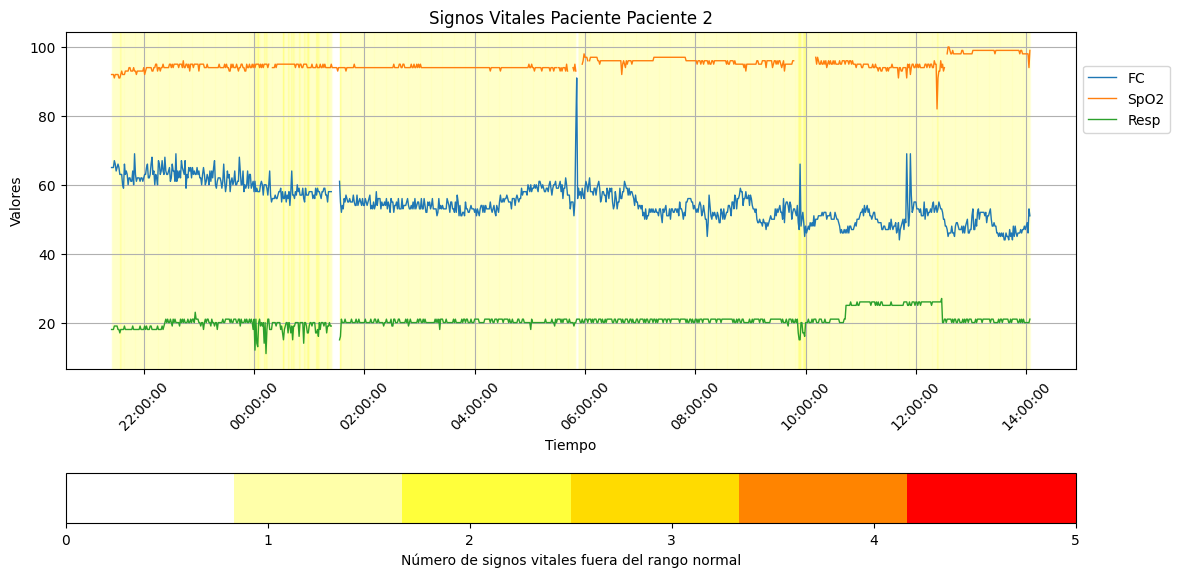

In [15]:
# Apply the preparation and visulize the vital signs
for patient_id, patient in enumerate(studied_patients):
    
    
    analyze_and_plot_patient(patient, f'Paciente {id_paciente}')

In [16]:
# Add a column for the number of anomalies at each time step
for patient_id, patient in enumerate(studied_patients):
    
    # Apply function to count anomalies
    patient['Anomalies'] = patient.apply(count_anomalies, axis=1)
    
    print(f"Paciente {patient_id} tiene {patient['Anomalies'].sum()} anomalías en total.")

Paciente 0 tiene 1018 anomalías en total.


In [17]:
# Calculate the most common number of anomalies
paciente0 = studied_patients[0]
most_common_anomalies = paciente0['Anomalies'].mode()[0]

# Initialize variables
anomaly_periods = []
interval_duration = pd.Timedelta(minutes=2)
# Set the start time as the first time in the 'Time' column
start_time = paciente0.index.min()
end_time = start_time + interval_duration

# Initialize a variable to track consecutive anomaly intervals
consecutive_anomalies = 0

while start_time < paciente0.index.max():
    # Filter the data within the current interval
    interval_data = paciente0[(paciente0.index >= start_time) & (paciente0.index < end_time)]
    
    # If there is data in this interval, process it
    if not interval_data.empty:
        # Find the highest anomaly level within the interval
        max_anomaly_level = interval_data['Anomalies'].max()
        
        # Append the interval details with the anomaly level
        anomaly_periods.append((start_time, end_time, max_anomaly_level))
        
        # Check if this interval has an anomaly level higher than the most common level
        if max_anomaly_level > most_common_anomalies:
            consecutive_anomalies += 1
        else:
            consecutive_anomalies = 0  # Reset if no anomaly
    else:
        consecutive_anomalies = 0  # Reset if there's no data in this interval
    
    # Move to the next interval
    start_time = end_time
    end_time = start_time + interval_duration

# Create a DataFrame to store the time frames, anomaly levels, and anomaly status
anomaly_df = pd.DataFrame(anomaly_periods, columns=['Start Time', 'End Time', 'Anomaly Level'])

# Set the 'Anomaly' column to True only if the anomaly level persists for more than 1 timeframe
anomaly_df['Anomaly'] = False
for i in range(1, len(anomaly_df)):
    if anomaly_df.loc[i, 'Anomaly Level'] > most_common_anomalies and anomaly_df.loc[i - 1, 'Anomaly Level'] > most_common_anomalies:
        anomaly_df.loc[i, 'Anomaly'] = True
        anomaly_df.loc[i - 1, 'Anomaly'] = True

# Display the updated DataFrame
anomaly_df


,Start Time,End Time,Anomaly Level,Anomaly
0,2025-04-20 21:25:00,2025-04-20 21:27:00,1,False
1,2025-04-20 21:27:00,2025-04-20 21:29:00,1,False
2,2025-04-20 21:29:00,2025-04-20 21:31:00,1,False
3,2025-04-20 21:31:00,2025-04-20 21:33:00,1,False
4,2025-04-20 21:33:00,2025-04-20 21:35:00,2,False
5,2025-04-20 21:35:00,2025-04-20 21:37:00,1,False
6,2025-04-20 21:37:00,2025-04-20 21:39:00,1,False
7,2025-04-20 21:39:00,2025-04-20 21:41:00,1,False
8,2025-04-20 21:41:00,2025-04-20 21:43:00,1,False
9,2025-04-20 21:43:00,2025-04-20 21:45:00,1,False


## 3.Utilizar Modelo HTM Original

### 3.1. Parametros del modelo

In [18]:
search_params = {'columnDimensions': [2048],
                 'sp_potentialPct': [0.4],
                 'sp_potentialRadius': [500],
                 'sp_stimulusThreshold': [5],
                 'sp_synPermInactiveDec': [0.005], #[0.001,0.005,0.01]
                 'sp_synPermActiveInc': [0.01], #[0.01,0.05,0.1]
                 'sp_synPermConnected': [0.2],
                 'sp_boostStrength': [0], #[1,1.5,2,3]
                 'tm_cellsPerColumn': [16],
                 'tm_activationThreshold':[17],
                 'tm_initialPermanence': [0.5],
                 'tm_connectedPermanence': [0.5],
                 'tm_minThreshold': [10],
                 'tm_maxNewSynapseCount': [32],
                 'tm_permanenceIncrement': [0.01], #[0.01,0.05,0.1]
                 'tm_permanenceDecrement': [0.1], #[0.01,0.05,0.1]
                 'tm_predictedSegmentDecrement': [0.001], # [0.001,0.005,0.01]
                 'tm_maxSegmentsPerCell': [128],
                 'tm_maxSynapsesPerSegment': [128],
                 'anom_wait_n': [0],      # [120,240,480,720,1440] tiempo de espera para calcular anomalias
                 'anom_window': [120],      # [120,240,480,720,1440] ventana de tiempo para el calculo de anomalias
                 'threshold': [0.1]       # list(np.arange(0.1, 0.3, 0.01)) umbral de deteccion de anomalias
                }        

combinations = list(itertools.product(*[val for key, val in search_params.items()]))

### 3.2. Ejecución del modelo

In [19]:
# Calculo de metricas:
def found_metrics(actual, predicted):
    Accuracy = accuracy_score(actual, predicted)
    Precision = precision_score(actual, predicted, zero_division=0)
    Sensitivity_recall = recall_score(actual, predicted, zero_division=0)
    F1_score = f1_score(actual, predicted, zero_division=0)
    return {"Accuracy": Accuracy, "Precision": Precision, "Sensitivity_recall": Sensitivity_recall, "F1_score": F1_score}

def run_detection(params, monitor, anomalies, search=True):
    
    monitor.reset_index(drop=True, inplace=True) 
    df = monitor.copy()
    anom_df = anomalies.copy()
    
    # Encoder for TIME
    DateTimeEncoder = DateEncoder(timeOfDay=(21, 0.1))
    
    # Encoder for FC
    FCscalarEncoderParams = ScalarEncoderParameters()
    FCscalarEncoderParams.maximum = 200
    FCscalarEncoderParams.minimum = 0
    FCscalarEncoderParams.size = 240
    FCscalarEncoderParams.activeBits = 31
    FCscalarEncoderParams.clipInput = True
    FCscalarEncoderParams.periodic = False
    FCscalarEncoder = ScalarEncoder(FCscalarEncoderParams)
    
    # Encoder for FR (Respiratory rate)
    FRscalarEncoderParams = ScalarEncoderParameters()
    FRscalarEncoderParams.maximum = 150
    FRscalarEncoderParams.minimum = 0
    FRscalarEncoderParams.size = 190
    FRscalarEncoderParams.activeBits = 15
    FRscalarEncoderParams.clipInput = True
    FRscalarEncoderParams.periodic = False
    FRscalarEncoder = ScalarEncoder(FRscalarEncoderParams)
    
    # Encoder for SPO2
    SPO2scalarEncoderParams = ScalarEncoderParameters()
    SPO2scalarEncoderParams.maximum = 100
    SPO2scalarEncoderParams.minimum = 50
    SPO2scalarEncoderParams.size = 140
    SPO2scalarEncoderParams.activeBits = 21
    SPO2scalarEncoderParams.clipInput = True
    SPO2scalarEncoderParams.periodic = False
    SPO2scalarEncoder = ScalarEncoder(SPO2scalarEncoderParams)
    
    # Encoder for ARTs (for example, systolic arterial pressure)
    ARTsEncoderParams = ScalarEncoderParameters()
    ARTsEncoderParams.maximum = 180  # adjust based on your data range
    ARTsEncoderParams.minimum = 80
    ARTsEncoderParams.size = 160
    ARTsEncoderParams.activeBits = 21
    ARTsEncoderParams.clipInput = True
    ARTsEncoderParams.periodic = False
    ARTsEncoder = ScalarEncoder(ARTsEncoderParams)
    
    # Encoder for ARTd (for example, diastolic arterial pressure)
    ARTdEncoderParams = ScalarEncoderParameters()
    ARTdEncoderParams.maximum = 100  # adjust based on your data range
    ARTdEncoderParams.minimum = 40
    ARTdEncoderParams.size = 160
    ARTdEncoderParams.activeBits = 21
    ARTdEncoderParams.clipInput = True
    ARTdEncoderParams.periodic = False
    ARTdEncoder = ScalarEncoder(ARTdEncoderParams)
    
    # Update the total encoding width by including the new encoders:
    encodingWidth = DateTimeEncoder.size
    if 'FC' in studied_vital_signs:
        encodingWidth += FCscalarEncoder.size
    if 'Resp' in studied_vital_signs:
        encodingWidth += FRscalarEncoder.size
    if 'SpO2' in studied_vital_signs:
        encodingWidth += SPO2scalarEncoder.size
    if 'ARTs' in studied_vital_signs:
        encodingWidth += ARTsEncoder.size
    if 'ARTd' in studied_vital_signs:
        encodingWidth += ARTdEncoder.size
    enc_info = Metrics([encodingWidth], 999999999)

    # Make the HTM. SpatialPooler & TemporalMemory & associated tools.
    sp = SpatialPooler(
        inputDimensions=(encodingWidth,),
        columnDimensions=(params[0],),
        potentialPct=params[1],
        potentialRadius=params[2],
        globalInhibition=True,
        stimulusThreshold=params[3],
        localAreaDensity=0.02, 
        synPermInactiveDec=params[4],
        synPermActiveInc=params[5], 
        synPermConnected=params[6],
        boostStrength=params[7],
        wrapAround=False
    )
    sp_info = Metrics(sp.getColumnDimensions(), 999999999)

    tm = TemporalMemory(
        columnDimensions=(params[0],),
        cellsPerColumn=params[8], 
        activationThreshold=params[9], 
        initialPermanence=params[10], 
        connectedPermanence=params[11], 
        minThreshold=params[12],
        maxNewSynapseCount=params[13],
        permanenceIncrement=params[14],
        permanenceDecrement=params[15],
        predictedSegmentDecrement=params[16],
        maxSegmentsPerCell=params[17],
        maxSynapsesPerSegment=params[18]
    )
    tm_info = Metrics([tm.numberOfCells()], 999999999)

    df['anomalySc'] = 0
    df['anomalyProb'] = 0
    df['anomalyLogProb'] = 0

    anomaly_history = AnomalyLikelihood()

    # Run the model for each record in the monitor dataframe:
    for count, record in df.iterrows():
        date_bits = DateTimeEncoder.encode(record['Time'])
        fc_bits = FCscalarEncoder.encode(record['FC']) if 'FC' in studied_vital_signs else None
        fr_bits = FRscalarEncoder.encode(record['Resp']) if 'Resp' in studied_vital_signs else None
        spo2_bits = SPO2scalarEncoder.encode(record['SpO2']) if 'SpO2' in studied_vital_signs else None
        arts_bits = ARTsEncoder.encode(record['ARTs']) if 'ARTs' in studied_vital_signs else None
        artd_bits = ARTdEncoder.encode(record['ARTd']) if 'ARTd' in studied_vital_signs else None

        # Concatenate only the encoded bits that are not None:
        encoded_bits = [date_bits]
        for bits in [fc_bits, fr_bits, spo2_bits, arts_bits, artd_bits]:
            if bits is not None:
                encoded_bits.append(bits)

        encoding = SDR(encodingWidth).concatenate(encoded_bits)
        enc_info.addData(encoding)
        
        activeColumns = SDR(sp.getColumnDimensions())
        sp.compute(encoding, True, activeColumns)
        sp_info.addData(activeColumns)
        
        tm.compute(activeColumns, learn=True)
        tm_info.addData(tm.getActiveCells().flatten())
        
        df.loc[count, 'anomalySc'] = tm.anomaly
        df.loc[count, 'anomalyLogProb'] = anomaly_history.get_log_likelihood(df.loc[count, 'anomalySc'])
    
    df['anom_pred'] = df['anomalyLogProb'].apply(lambda x: True if x > params[21] else False)
    
    for idx, row in anom_df.iterrows():
        anom_period = df.loc[(df['Time'] >= row['Start Time']) & (df['Time'] < row['End Time'])]
        alarms = [i for i, val in enumerate(anom_period.anom_pred) if val]
        if alarms:
            anom_df.loc[idx, 'cnt_pred'] = len(alarms)
            anom_df.loc[idx, 'max_anomLikelihood_pred'] = anom_period.iloc[alarms]['anomalyLogProb'].max()
            anom_df.loc[idx, 'time_pred'] = anom_period.iloc[alarms]['Time'].min()
            anom_df.loc[idx, 'anom_pred'] = 1
        else:
            anom_df.loc[idx, 'anom_pred'] = 0
    
    if search:
        anom_eval = anom_df[anom_df['Start Time'] > df.iloc[params[19]]['Time']]
        metricas = found_metrics(anom_eval['Anomaly'], anom_eval.anom_pred)
    
        params_dict = {
            'columnDimensions': params[0],
            'potentialPct': params[1],
            'potentialRadius': params[2],
            'stimulusThreshold': params[3],
            'synPermInactiveDec': params[4],
            'synPermActiveInc': params[5],
            'synPermConnected': params[6],
            'boostStrength': params[7],
            'cellsPerColumn': params[8],
            'activationThreshold': params[9],
            'initialPermanence': params[10],
            'connectedPermanence': params[11],
            'minThreshold': params[12],
            'maxNewSynapseCount': params[13],
            'permanenceIncrement': params[14],
            'permanenceDecrement': params[15],
            'predictedSegmentDecrement': params[16],
            'maxSegmentsPerCell': params[17],
            'maxSynapsesPerSegment': params[18],
            'anom_wait_n': params[19],
            'anom_window': params[20],
            'threshold': params[21]
        }
        return {**params_dict, **metricas}
    else:
        return {'monitor': df, 'anomalies': anom_df}


In [20]:
paciente0.reset_index(inplace=True)
start_time = time.time()

# Run the detection function
result_1 = run_detection(combinations[0], monitor=paciente0, anomalies=anomaly_df, search=False)
execution_time = time.time() - start_time

results1 = result_1['anomalies']

num_data_points = results1.shape[0] if hasattr(results1, 'shape') else len(results1)

print(f"Execution time: {execution_time:.2f} seconds")
print(f"Number of data points analyzed: {num_data_points}")


/tmp/ipykernel_81/2615860022.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.05000000074505806' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[count, 'anomalySc'] = tm.anomaly
/tmp/ipykernel_81/2615860022.py:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0022276395086089163' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[count, 'anomalyLogProb'] = anomaly_history.get_log_likelihood(df.loc[count, 'anomalySc'])


Execution time: 8.68 seconds
Number of data points analyzed: 500


### 3.4. Visualizar Anomalias

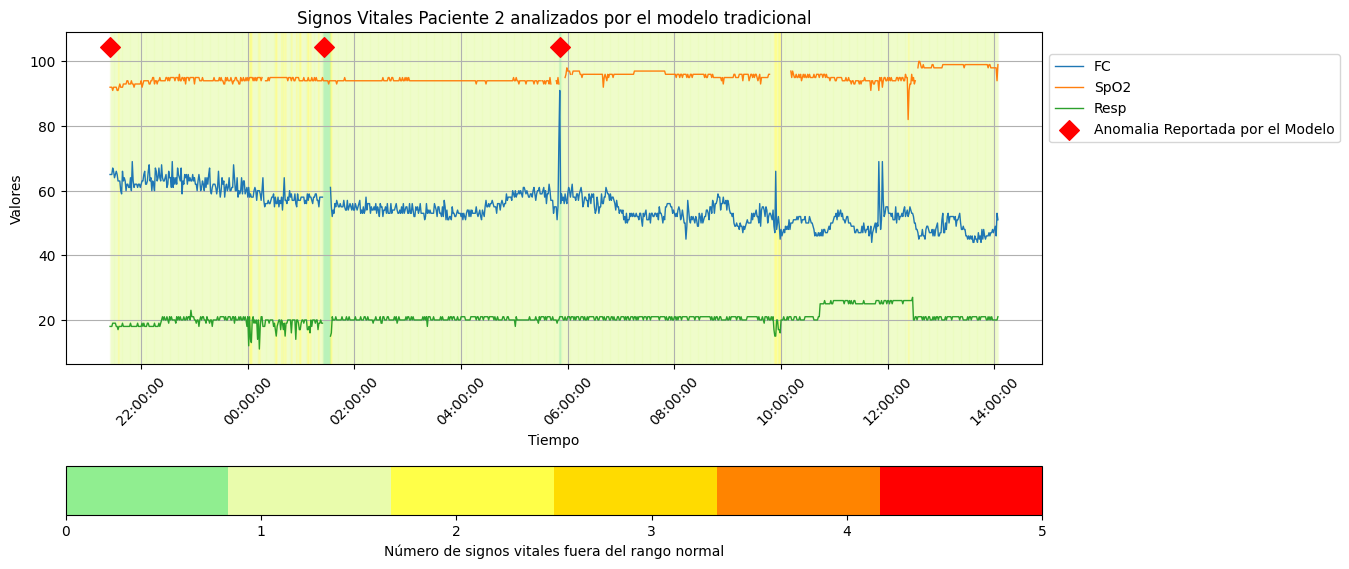

In [21]:
# Function to analyze and plot patient data along with model anomaly predictions
def analyze_and_plot_patient(patient_data, patient_id, results1):
    # Count anomalies for each row of patient data
    patient_data['Anomalies'] = patient_data.apply(count_anomalies, axis=1)
    
    # Define a dynamic color mapping based on the number of anomalies
    max_anomalies = len(normal_ranges)  # Maximum possible anomalies
    colors = ['lightgreen', '#ffffB3', 'yellow', 'orange', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", colors, N=max_anomalies + 1)
    norm = mcolors.Normalize(vmin=0, vmax=max_anomalies)
    color_values = patient_data['Anomalies'].apply(lambda x: cmap(norm(x)))
    
    # Create the base plot
    plt.figure(figsize=(16, 6))
    
    # Plot all vital signs dynamically
    for col in studied_vital_signs:
        plt.plot(patient_data.index, patient_data[col], label=col, linewidth=1)
    
    # Customize plot settings
    plt.title(f'Signos Vitales Paciente {patient_id} analizados por el modelo tradicional')
    plt.xlabel('Tiempo')
    plt.ylabel('Valores')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Add a color bar for the number of anomalies
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=plt.gca(), orientation='horizontal', pad=0.2, ticks=range(max_anomalies + 1), label='Número de signos vitales fuera del rango normal')
    
    # Apply background coloring based on the number of anomalies
    for i in range(len(patient_data.index) - 1):
        plt.axvspan(patient_data.index[i], patient_data.index[i + 1], color=color_values.iloc[i], alpha=0.25)
    
    # Plot red diamond markers for model predicted anomalies.
    # Filter predictions where an anomaly was predicted (assuming anom_pred == 1.0 indicates an anomaly)
    predictions = results1.loc[results1['anom_pred'] == 1.0].copy()
    if not predictions.empty:
        # Ensure 'time_pred' and 'End Time' columns are in datetime format
        predictions['time_pred'] = pd.to_datetime(predictions['time_pred'],  format="%Y/%m/%d %H:%M:%S")
        predictions['End Time'] = pd.to_datetime(predictions['End Time'],  format="%Y/%m/%d %H:%M:%S")
        
        # Determine a y-coordinate for the marker: slightly above the maximum value among all vital signs.
        vitals_max = patient_data[list(studied_vital_signs)].max().max()
        vitals_min = patient_data[list(studied_vital_signs)].min().min()
        offset = (vitals_max - vitals_min) * 0.05
        y_marker = vitals_max + offset
        
        # To avoid duplicate legend entries, label only the first marker.
        first_marker = True
        for _, row in predictions.iterrows():
            # Plot the red diamond marker
            if first_marker:
                plt.scatter(row['time_pred'], y_marker, marker='D', color='red', s=100, zorder=5,
                            label='Anomalia Reportada por el Modelo')
                first_marker = False
            else:
                plt.scatter(row['time_pred'], y_marker, marker='D', color='red', s=100, zorder=5)
            
            ## Calculate the duration (difference between 'End Time' and 'time_pred') in minutes
            #duration = row['End Time'] - row['time_pred']
            #duration_minutes = duration.total_seconds() / 60
            #duration_str = f"{duration_minutes:.2f} min"
            
            ## Annotate the marker with the duration text rotated vertically (90°)
            #plt.text(row['time_pred'], y_marker + 1.5 * offset, duration_str,
                     # fontsize=9, color='black', ha='center', va='bottom', rotation=90, rotation_mode='anchor')
    
    # Format the x-axis to show time in HH:MM:SS format
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))  # Position legend outside the plot area
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to leave space for the legend
    plt.show()

# Example usage:
# Ensure that 'patient' and 'paciente0' are defined DataFrames with a proper 'Time' column
patient.set_index('Time', inplace=True)
analyze_and_plot_patient(paciente0, str(id_paciente), results1)


## 4. Nueva Arquitectura del Modelo

### 4.1. Algoritmo del predicción usando parejas maximas

In [22]:
def run_detection_pair(params, monitor, anomalies, selected_signals, search=True):
    # Validate selected_signals: must be a list of exactly 2 allowed signals.
    allowed_signals = {"FC", "Resp", "SpO2", "ARTs", "ARTd"}
    if not isinstance(selected_signals, list) or len(selected_signals) != 2 or not set(selected_signals).issubset(allowed_signals):
        raise ValueError("selected_signals must be a list of 2 signals chosen from: 'FC', 'Resp', 'SpO2', 'ARTs', 'ARTd'.")
    
    monitor.reset_index(drop=True, inplace=True)
    df = monitor.copy()
    anom_df = anomalies.copy()

    # Always create the Time encoder:
    DateTimeEncoder = DateEncoder(timeOfDay=(21, 0.1))
    
    # Create a dictionary to hold encoders for the selected signals.
    # Each entry is a tuple: (encoder_object, column_name in the dataframe)
    signal_encoders = {}
    
    if "FC" in selected_signals:
        FCscalarEncoderParams = ScalarEncoderParameters()
        FCscalarEncoderParams.maximum = 200
        FCscalarEncoderParams.minimum = 0
        FCscalarEncoderParams.size = 240
        FCscalarEncoderParams.activeBits = 31
        FCscalarEncoderParams.clipInput = True
        FCscalarEncoderParams.periodic = False
        FCscalarEncoder = ScalarEncoder(FCscalarEncoderParams)
        signal_encoders["FC"] = (FCscalarEncoder, "FC")
    
    if "Resp" in selected_signals:
        FRscalarEncoderParams = ScalarEncoderParameters()
        FRscalarEncoderParams.maximum = 150
        FRscalarEncoderParams.minimum = 0
        FRscalarEncoderParams.size = 190
        FRscalarEncoderParams.activeBits = 15
        FRscalarEncoderParams.clipInput = True
        FRscalarEncoderParams.periodic = False
        FRscalarEncoder = ScalarEncoder(FRscalarEncoderParams)
        signal_encoders["Resp"] = (FRscalarEncoder, "Resp")
    
    if "SpO2" in selected_signals:
        SPO2scalarEncoderParams = ScalarEncoderParameters()
        SPO2scalarEncoderParams.maximum = 100
        SPO2scalarEncoderParams.minimum = 50
        SPO2scalarEncoderParams.size = 140
        SPO2scalarEncoderParams.activeBits = 21
        SPO2scalarEncoderParams.clipInput = True
        SPO2scalarEncoderParams.periodic = False
        SPO2scalarEncoder = ScalarEncoder(SPO2scalarEncoderParams)
        signal_encoders["SpO2"] = (SPO2scalarEncoder, "SpO2")
    
    if "ARTs" in selected_signals:
        ARTsEncoderParams = ScalarEncoderParameters()
        ARTsEncoderParams.maximum = 180  # adjust based on your data range
        ARTsEncoderParams.minimum = 80
        ARTsEncoderParams.size = 160
        ARTsEncoderParams.activeBits = 21
        ARTsEncoderParams.clipInput = True
        ARTsEncoderParams.periodic = False
        ARTsEncoder = ScalarEncoder(ARTsEncoderParams)
        signal_encoders["ARTs"] = (ARTsEncoder, "ARTs")
    
    if "ARTd" in selected_signals:
        ARTdEncoderParams = ScalarEncoderParameters()
        ARTdEncoderParams.maximum = 100  # adjust based on your data range
        ARTdEncoderParams.minimum = 40
        ARTdEncoderParams.size = 160
        ARTdEncoderParams.activeBits = 21
        ARTdEncoderParams.clipInput = True
        ARTdEncoderParams.periodic = False
        ARTdEncoder = ScalarEncoder(ARTdEncoderParams)
        signal_encoders["ARTd"] = (ARTdEncoder, "ARTd")
    
    # Calculate the total encoding width: Time always plus the chosen signals.
    encodingWidth = DateTimeEncoder.size + sum(encoder.size for encoder, _ in signal_encoders.values())
    enc_info = Metrics([encodingWidth], 999999999)

    # Make the HTM components (SpatialPooler & TemporalMemory):
    sp = SpatialPooler(
        inputDimensions=(encodingWidth,),
        columnDimensions=(params[0],),
        potentialPct=params[1],
        potentialRadius=params[2],
        globalInhibition=True,
        stimulusThreshold=params[3],
        localAreaDensity=0.02, 
        synPermInactiveDec=params[4],
        synPermActiveInc=params[5], 
        synPermConnected=params[6],
        boostStrength=params[7],
        wrapAround=False
    )
    sp_info = Metrics(sp.getColumnDimensions(), 999999999)

    tm = TemporalMemory(
        columnDimensions=(params[0],),
        cellsPerColumn=params[8], 
        activationThreshold=params[9], 
        initialPermanence=params[10], 
        connectedPermanence=params[11], 
        minThreshold=params[12],
        maxNewSynapseCount=params[13],
        permanenceIncrement=params[14],
        permanenceDecrement=params[15],
        predictedSegmentDecrement=params[16],
        maxSegmentsPerCell=params[17],
        maxSynapsesPerSegment=params[18]
    )
    tm_info = Metrics([tm.numberOfCells()], 999999999)

    # Initialize anomaly-related columns as float
    df['anomalySc'] = 0.0
    df['anomalyProb'] = 0.0
    df['anomalyLogProb'] = 0.0

    anomaly_history = AnomalyLikelihood()

    # Run the model for each record:
    for count, record in df.iterrows():
        
        # Encode time always.
        date_bits = DateTimeEncoder.encode(record['Time'])
        encoding_list = [date_bits]
        
        # Encode each selected signal.
        for key, (encoder, col_name) in signal_encoders.items():
            bits = encoder.encode(record[col_name])
            encoding_list.append(bits)
        
        # Concatenate all encoded bits into one SDR.
        encoding = SDR(encodingWidth).concatenate(encoding_list)
        enc_info.addData(encoding)
        
        activeColumns = SDR(sp.getColumnDimensions())
        sp.compute(encoding, True, activeColumns)
        sp_info.addData(activeColumns)
        
        tm.compute(activeColumns, learn=True)
        tm_info.addData(tm.getActiveCells().flatten())
        
        df.loc[count, 'anomalySc'] = tm.anomaly
        df.loc[count, 'anomalyLogProb'] = anomaly_history.get_log_likelihood(df.loc[count, 'anomalySc'])
    
    # Determine anomaly predictions.
    df['anom_pred'] = df['anomalyLogProb'].apply(lambda x: True if x > params[21] else False)
    
    for idx, row in anom_df.iterrows():
        anom_period = df.loc[(df['Time'] >= row['Start Time']) & (df['Time'] < row['End Time'])]
        alarms = [i for i, val in enumerate(anom_period.anom_pred) if val]
        if alarms:
            anom_df.loc[idx, 'cnt_pred'] = len(alarms)
            anom_df.loc[idx, 'max_anomLikelihood_pred'] = anom_period.iloc[alarms]['anomalyLogProb'].max()
            anom_df.loc[idx, 'time_pred'] = anom_period.iloc[alarms]['Time'].min()
            anom_df.loc[idx, 'anom_pred'] = 1
        else:
            anom_df.loc[idx, 'anom_pred'] = 0
    
    if search:
        anom_eval = anom_df[anom_df['Start Time'] > df.iloc[params[19]]['Time']]
        metricas = found_metrics(anom_eval['Anomaly'], anom_eval.anom_pred)
    
        params_dict = {
            'columnDimensions': params[0],
            'potentialPct': params[1],
            'potentialRadius': params[2],
            'stimulusThreshold': params[3],
            'synPermInactiveDec': params[4],
            'synPermActiveInc': params[5],
            'synPermConnected': params[6],
            'boostStrength': params[7],
            'cellsPerColumn': params[8],
            'activationThreshold': params[9],
            'initialPermanence': params[10],
            'connectedPermanence': params[11],
            'minThreshold': params[12],
            'maxNewSynapseCount': params[13],
            'permanenceIncrement': params[14],
            'permanenceDecrement': params[15],
            'predictedSegmentDecrement': params[16],
            'maxSegmentsPerCell': params[17],
            'maxSynapsesPerSegment': params[18],
            'anom_wait_n': params[19],
            'anom_window': params[20],
            'threshold': params[21],
            'selected_signals': selected_signals
        }
        return {**params_dict, **metricas}
    else:
        return {'monitor': df, 'anomalies': anom_df}


### 4.2. Calcular Parejas Maximas

In [23]:
# Generate all combinations of 2 signals
vital_signs_combinations = list(itertools.combinations(studied_vital_signs, 2))
# combinations now contains:
# [('FC', 'SpO2'), ('FC', 'Resp'), ('FC', 'ARTs'), ('FC', 'ARTd'),
#  ('SpO2', 'Resp'), ('SpO2', 'ARTs'), ('SpO2', 'ARTd'),
#  ('Resp', 'ARTs'), ('Resp', 'ARTd'), ('ARTs', 'ARTd')]

# Dictionary to store anomalies for each pair
results = {}


In [24]:
paciente0.reset_index(inplace=True)
start_time = time.time()

# Loop through each combination, running the detection and storing anomalies
for pair in vital_signs_combinations:
    
    # Convert tuple to list for the selected_signals argument if needed
    selected_signals = list(pair)
    
    # Run detection for the current pair
    result = run_detection_pair(combinations[0], monitor=paciente0, anomalies=anomaly_df, selected_signals=selected_signals, search=False)
    
    # Save the anomalies using a key for clarity
    results[f'{pair[0]} y {pair[1]}'] = result['anomalies']

    
num_data_points = results1.shape[0] if hasattr(results1, 'shape') else len(results1)
execution_time = time.time() - start_time

print(f"Execution time: {execution_time:.2f} seconds")
print(f"Number of data points analyzed: {num_data_points*len(vital_signs_combinations)}")

Execution time: 25.81 seconds
Number of data points analyzed: 1500


In [25]:
# Imprimir los resultados de las anomalías para cada par de señales
for pair, anomalies in results.items():
    print(f"Anomalías para el par {pair}:")
    print(anomalies)
    print("\n")

Anomalías para el par FC y SpO2:
             Start Time            End Time  Anomaly Level  Anomaly  cnt_pred  \
0   2025-04-20 21:25:00 2025-04-20 21:27:00              1    False       2.0   
1   2025-04-20 21:27:00 2025-04-20 21:29:00              1    False       NaN   
2   2025-04-20 21:29:00 2025-04-20 21:31:00              1    False       NaN   
3   2025-04-20 21:31:00 2025-04-20 21:33:00              1    False       NaN   
4   2025-04-20 21:33:00 2025-04-20 21:35:00              2    False       NaN   
5   2025-04-20 21:35:00 2025-04-20 21:37:00              1    False       NaN   
6   2025-04-20 21:37:00 2025-04-20 21:39:00              1    False       NaN   
7   2025-04-20 21:39:00 2025-04-20 21:41:00              1    False       NaN   
8   2025-04-20 21:41:00 2025-04-20 21:43:00              1    False       NaN   
9   2025-04-20 21:43:00 2025-04-20 21:45:00              1    False       NaN   
10  2025-04-20 21:45:00 2025-04-20 21:47:00              1    False       Na

In [26]:
# Post processing step: si un par de señales tiene una anomalia, pero esos dos signos vitales estan dentro del rango normal, entonces se elimina la anomalia, poniendo anom_pred a 0
def post_process_anomalies(results, normal_ranges):
    for pair, anomalies in results.items():
        for idx, row in anomalies.iterrows():
            # Check if the anomaly is predicted
            if row['anom_pred'] == 1:
                # Check if both vital signs are within normal ranges, only if both are in a normal range, change anom_pred to 0
                vital_signs = pair.split(' y ')
                print("Checking pair:", vital_signs)
                print("Row data:", row)
                within_normal_range = True
                for vital_sign in vital_signs:
                    if vital_sign in normal_ranges:
                        
                        age_range = get_age_range(studied_patients_ages[0], vital_sign)
                        if age_range and age_range in normal_ranges[vital_sign]:
                            min_val, max_val = normal_ranges[vital_sign][age_range]
                            
                            # the actual value of the vital sings are in patient data, but we need to get the timestamp from the row
                            start_time = row['Start Time']
                            end_time = row['End Time']
                            # Filter the patient data to get the values at the start and end time
                            vital_sign_values = paciente0[(paciente0['Time'] >= start_time) & (paciente0['Time'] < end_time)][vital_sign]
                            if not vital_sign_values.empty:
                                
                                # Check if all values are within the normal range
                                if not ((vital_sign_values >= min_val) & (vital_sign_values <= max_val)).all():
                                    within_normal_range = False
                                    print(f"Anomaly for {pair} at index {idx} is outside normal range for {vital_sign}.")
                                    break
                            else:
                                within_normal_range = False
                                print(f"No data available for {vital_sign} at the specified time range for anomaly {pair} at index {idx}.")
                                break
                        
                        
                if within_normal_range:
                    print(f"Anomaly for {pair} at index {idx} is within normal range, setting anom_pred to 0.")
                    
                    anomalies.at[idx, 'anom_pred'] = 0
                    
    return results

results = post_process_anomalies(results, normal_ranges)



Checking pair: ['FC', 'SpO2']
Row data: Start Time                 2025-04-20 21:25:00
End Time                   2025-04-20 21:27:00
Anomaly Level                                1
Anomaly                                  False
cnt_pred                                   2.0
max_anomLikelihood_pred                    1.0
time_pred                  2025-04-20 21:25:00
anom_pred                                  1.0
Name: 0, dtype: object
Anomaly for FC y SpO2 at index 0 is outside normal range for FC.
Checking pair: ['FC', 'SpO2']
Row data: Start Time                 2025-04-21 01:25:00
End Time                   2025-04-21 01:27:00
Anomaly Level                                0
Anomaly                                  False
cnt_pred                                   1.0
max_anomLikelihood_pred                    1.0
time_pred                  2025-04-21 01:26:00
anom_pred                                  1.0
Name: 120, dtype: object
Anomaly for FC y SpO2 at index 120 is outside normal ra

## 5. Composición de modelos Para la nueva Arquitectura

### 5.1. Estrategia 1: Utilizar el modelo de mayor confianza como representante de la anomalia.

OBJETIVO: Lo que buscan los medicos es buscar que conjunto de señales están mal/se están poniendo mal, esto les permite afirmar "que señales influyen mas en la condición del paciente" y tratarlo acorde a estos resultados

SOLUCIÓN: podemos afirmar que la pareja de señales que se está poniendo peor es aquella que reporta una anomalia con mayor confianza.  

In [27]:
import pandas as pd

# Step 1: Add a new column to each dataframe indicating the pair name.
dfs = [df.assign(Pair=pair) for pair, df in results.items()]

# Step 2: Combine all dataframes into one.
combined_df = pd.concat(dfs, ignore_index=True)

# Step 3: Identify unique time windows based on 'Start Time' and 'End Time'.
time_windows = combined_df[['Start Time', 'End Time']].drop_duplicates()

# Step 4: For each time window, find the row with the highest anomaly confidence,
#         or set default values if all anomaly probabilities are NaN.
final_rows = []  # To store the selected row information for each time window.
for _, time_window in time_windows.iterrows():
    start_time = time_window['Start Time']
    end_time = time_window['End Time']
    
    # Filter combined_df to the current time window.
    window_df = combined_df[(combined_df['Start Time'] == start_time) &
                              (combined_df['End Time'] == end_time)]
    
    # Count the number of pairs reporting an anomaly (where Anomaly is True)
    anomaly_count = window_df['anom_pred'].sum()  # True values count as 1
    
    if not window_df.empty:
        # Check if all values in "max_anomLikelihood_pred" are NaN.
        if window_df['max_anomLikelihood_pred'].isna().all():
            final_rows.append({
                'Start Time': start_time,
                'End Time': end_time,
                'Pair': "None",
                'Anomaly Level': 0,
                'Confidence': 0,
                'Anomaly Count': anomaly_count
            })
        else:
            # Select the row with the highest anomaly probability.
            best_idx = window_df['max_anomLikelihood_pred'].idxmax()
            best_row = window_df.loc[best_idx]
            final_rows.append({
                'Start Time': start_time,
                'End Time': end_time,
                'Pair': best_row['Pair'],
                'Anomaly Level': best_row['Anomaly Level'],
                'Confidence': best_row['max_anomLikelihood_pred'],
                'Anomaly Count': anomaly_count
            })

# Step 5: Create the final combined dataframe from the collected rows.
results_combined = pd.DataFrame(final_rows)

# Optionally, sort the final results by start time for clarity.
results_combined.sort_values('Start Time', inplace=True)

print(results_combined)


             Start Time            End Time         Pair  Anomaly Level  \
0   2025-04-20 21:25:00 2025-04-20 21:27:00    FC y SpO2              1   
1   2025-04-20 21:27:00 2025-04-20 21:29:00         None              0   
2   2025-04-20 21:29:00 2025-04-20 21:31:00         None              0   
3   2025-04-20 21:31:00 2025-04-20 21:33:00         None              0   
4   2025-04-20 21:33:00 2025-04-20 21:35:00         None              0   
5   2025-04-20 21:35:00 2025-04-20 21:37:00         None              0   
6   2025-04-20 21:37:00 2025-04-20 21:39:00         None              0   
7   2025-04-20 21:39:00 2025-04-20 21:41:00         None              0   
8   2025-04-20 21:41:00 2025-04-20 21:43:00         None              0   
9   2025-04-20 21:43:00 2025-04-20 21:45:00         None              0   
10  2025-04-20 21:45:00 2025-04-20 21:47:00         None              0   
11  2025-04-20 21:47:00 2025-04-20 21:49:00         None              0   
12  2025-04-20 21:49:00 2

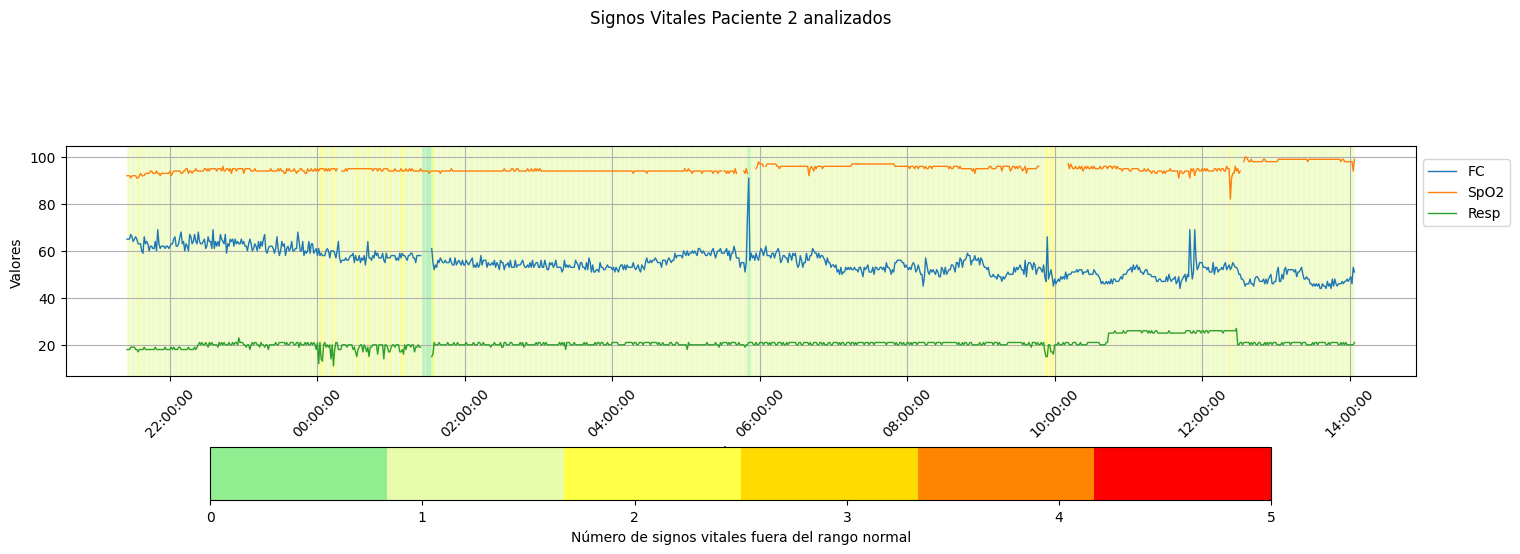

In [28]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

# Function to analyze and plot patient data along with model anomaly predictions.
# The background is shaded according to the number of pairs reporting anomalies.
# Above each diamond marker, the origin pair is annotated vertically.
def analyze_and_plot_patient(patient_data, patient_id, results1):
    # Count anomalies for each row of patient data
    patient_data['Anomalies'] = patient_data.apply(count_anomalies, axis=1)
    
    # Define a dynamic color mapping based on the number of anomalies
    max_anomalies = len(normal_ranges)  # Maximum possible anomalies
    colors = ['lightgreen', '#ffffB3', 'yellow', 'orange', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", colors, N=max_anomalies + 1)
    norm = mcolors.Normalize(vmin=0, vmax=max_anomalies)
    color_values = patient_data['Anomalies'].apply(lambda x: cmap(norm(x)))
    
    # Create the base plot
    plt.figure(figsize=(18, 6))
    
    # Plot all vital signs dynamically
    for col in studied_vital_signs:
        plt.plot(patient_data.index, patient_data[col], label=col, linewidth=1)
    
    # Raise the title much higher using the 'y' parameter (e.g., y=1.2)
    plt.title(f'Signos Vitales Paciente {patient_id} analizados', y=1.5)
    plt.xlabel('Tiempo')
    plt.ylabel('Valores')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Add a color bar for the number of anomalies
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=plt.gca(), orientation='horizontal', pad=0.2, ticks=range(max_anomalies + 1), label='Número de signos vitales fuera del rango normal')
    
    # Apply background coloring based on the number of anomalies
    for i in range(len(patient_data.index) - 1):
        plt.axvspan(patient_data.index[i], patient_data.index[i + 1], 
                    color=color_values.iloc[i], alpha=0.25)
    
    # Plot diamond markers for model predicted anomalies.
    # Filter predictions based on Confidence and Anomaly Count.
    predictions = results1.loc[
        (results1['Confidence'] >= 0.1) & (results1['Confidence'] <= 1.0) & (results1['Anomaly Count'] >= 7.0)
    ].copy()
    
    if not predictions.empty:
        # Ensure time columns are in datetime format
        predictions['Start Time'] = pd.to_datetime(predictions['Start Time'],  format="%Y/%m/%d %H:%M:%S")
        predictions['End Time'] = pd.to_datetime(predictions['End Time'],  format="%Y/%m/%d %H:%M:%S")
        
        
        # Determine a y-coordinate for the markers: slightly above the maximum value among all vital signs.
        vitals_max = patient_data[list(studied_vital_signs)].max().max()
        vitals_min = patient_data[list(studied_vital_signs)].min().min()
        offset = (vitals_max - vitals_min) * 0.05
        y_marker = vitals_max + offset
        # Increase text_offset to add more spacing between the diamond and its annotation.
        text_offset = (vitals_max - vitals_min) * 0.08
        
        first_marker = True
        for _, row in predictions.iterrows():
            # Plot the diamond marker (colored red)
            marker_color = 'red'
            if first_marker:
                plt.scatter(row['Start Time'], y_marker, marker='D', color=marker_color, s=100, zorder=5,
                            label='Anomalia Reportada por el Modelo')
                first_marker = False
            else:
                plt.scatter(row['Start Time'], y_marker, marker='D', color=marker_color, s=100, zorder=5)
            
            # Annotate above the diamond with the origin pair, rotated vertically
            plt.text(row['Start Time'], y_marker + text_offset, str(row['Pair']),
                     horizontalalignment='center', verticalalignment='bottom',
                     fontsize=10, color='black', rotation=90)
    
    # Format the x-axis to show time in HH:MM:SS format
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))  # Position legend outside the plot area
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to leave space for the legend and raised title
    plt.show()
    
    
patient.set_index('Time', inplace=True)
analyze_and_plot_patient(paciente0, patient_id=str(id_paciente), results1=results_combined)


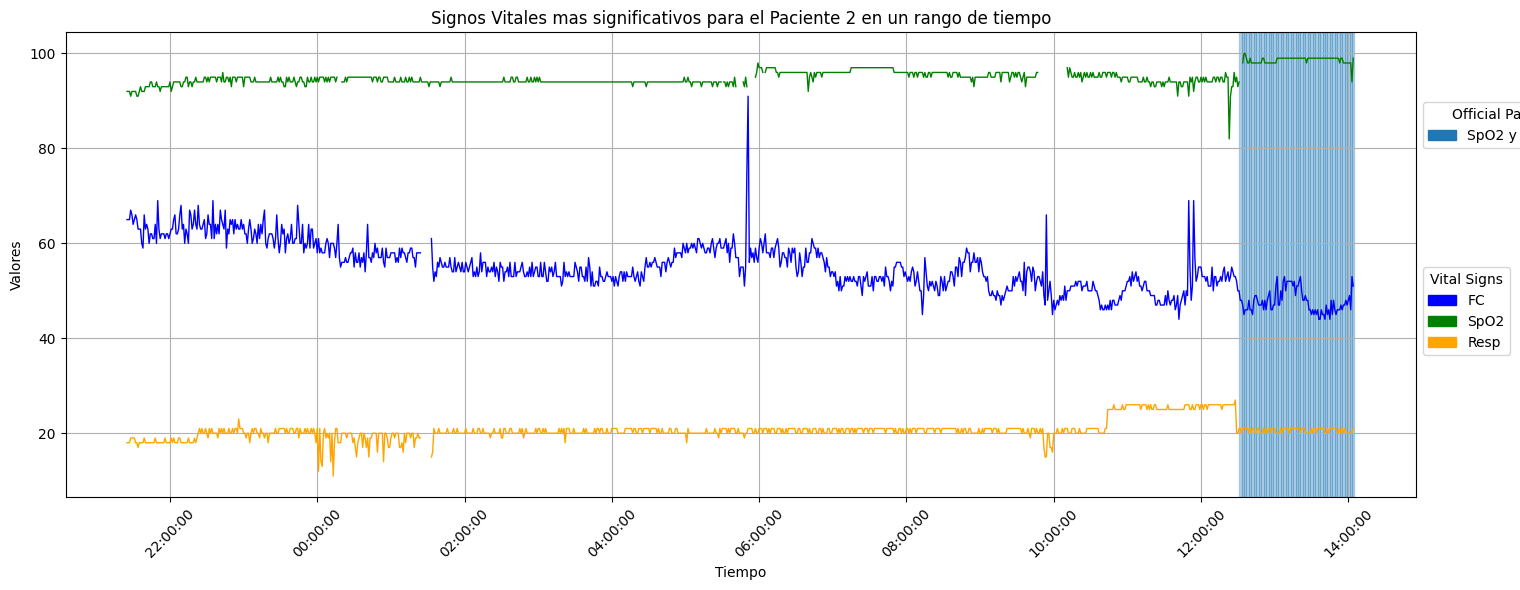

In [29]:
##### import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Define normal ranges for vitals
normal_ranges = {
    'FC': (70, 120),
    'Resp': (12, 16),
    'SpO2': (88, 1000),
    'ARTs': (95, 135),
    'ARTd': (58, 88)
}

# Designated colors for each vital sign
vital_sign_colors = {
    'FC': 'blue',
    'Resp': 'orange',
    'SpO2': 'green',
    'ARTs': 'red',
    'ARTd': 'purple'
}

# Function to count anomalies in a row based on the defined normal ranges
def count_anomalies(row):
    anomalies = 0
    for col in studied_vital_signs:
        if row[col] < normal_ranges[col][0] or row[col] > normal_ranges[col][1]:
            anomalies += 1
    return anomalies

# Function to process results_combined to compute the "official_pair" per row.
def compute_official_pair(results_combined):
    # Ensure the dataframe is sorted by Start Time.
    rows = results_combined.sort_values("Start Time").reset_index(drop=True)
    n = len(rows)
    official_pairs = []
    current_official = None  # Track the last official pair

    for i in range(n):
        current_val = rows.loc[i, "Pair"]
        # If current value is None (or string "None"), then use the last official pair if available.
        if pd.isnull(current_val) or current_val == "None":
            official_pairs.append(current_official if current_official is not None else "None")
        else:
            # If no official pair has been set, check if the new pair appears for at least 3 consecutive rows.
            if current_official is None:
                run_length = 1
                for j in range(i+1, min(i+3, n)):
                    if rows.loc[j, "Pair"] == current_val:
                        run_length += 1
                    else:
                        break
                if run_length >= 3:
                    current_official = current_val
                    official_pairs.append(current_val)
                else:
                    official_pairs.append(current_official if current_official is not None else "None")
            else:
                # If we already have an official pair, check if the new one is stable for at least 3 rows.
                if current_val == current_official:
                    official_pairs.append(current_val)
                else:
                    run_length = 1
                    for j in range(i+1, min(i+3, n)):
                        if rows.loc[j, "Pair"] == current_val:
                            run_length += 1
                        else:
                            break
                    if run_length >= 3:
                        current_official = current_val
                        official_pairs.append(current_val)
                    else:
                        # Not enough evidence to change, so continue with the current official pair.
                        official_pairs.append(current_official)
    rows["official_pair"] = official_pairs
    return rows

# Function to analyze and plot patient vital signs with background shading according to
# the official representative pair, and also add a separate legend for vital sign line colors.
def analyze_and_plot_patient_by_pair_with_official(patient_data, patient_id, results_combined):
    # Process the combined results to compute the official pair per interval.
    processed_results = compute_official_pair(results_combined)
    
    # Create a color mapping for official pairs.
    unique_officials = [p for p in processed_results["official_pair"].unique() if p != "None"]
    cmap_mpl = plt.get_cmap('tab10')
    pair_color_map = {pair: cmap_mpl(i) for i, pair in enumerate(unique_officials)}
    # Map "None" to white.
    pair_color_map["None"] = "white"
    
    # Create the base plot.
    plt.figure(figsize=(18, 6))
    
    # Plot each vital sign using its designated color.
    for col in studied_vital_signs:
        plt.plot(patient_data.index, patient_data[col], label=col, color=vital_sign_colors[col], linewidth=1)
    
    plt.title(f'Signos Vitales mas significativos para el Paciente {patient_id} en un rango de tiempo')
    plt.xlabel('Tiempo')
    plt.ylabel('Valores')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Shade the background based on the official representative pair for each time interval.
    for idx, row in processed_results.iterrows():
        start_time = pd.to_datetime(row['Start Time'],  format="%Y/%m/%d %H:%M:%S")
        end_time = pd.to_datetime(row['End Time'],  format="%Y/%m/%d %H:%M:%S")
        off_pair = row["official_pair"]
        color = pair_color_map.get(off_pair, "white")
        plt.axvspan(start_time, end_time, color=color, alpha=0.3)
    
    # Build a custom legend for official pairs (excluding "None").
    official_handles = [mpatches.Patch(color=pair_color_map[pair], label=pair) 
                        for pair in pair_color_map if pair != "None"]
    official_legend = plt.legend(handles=official_handles, loc='center left', bbox_to_anchor=(1, 0.8),
                                 title="Official Pair")
    plt.gca().add_artist(official_legend)
    
    # Build a second legend for the vital sign line colors.
    vital_handles = [mpatches.Patch(color=vital_sign_colors[col], label=col) for col in studied_vital_signs]
    plt.legend(handles=vital_handles, loc='center left', bbox_to_anchor=(1, 0.4), title="Vital Signs")
    
    # Format the x-axis to show time in HH:MM:SS format.
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# Example usage:
# patient_data should be a DataFrame indexed by time with columns: 'FC', 'Resp', 'SpO2', 'ARTs', 'ARTd'.
# results_combined is a DataFrame with columns:
# "Start Time", "End Time", "Pair", "Anomaly Level", "Confidence", "Anomaly".
#
# Example:
# results_combined = pd.DataFrame({
#     "Start Time": ["2025-02-19 11:41:00", "2025-02-19 11:43:00", "2025-02-19 11:45:00", "2025-02-19 11:47:00"],
#     "End Time": ["2025-02-19 11:43:00", "2025-02-19 11:45:00", "2025-02-19 11:47:00", "2025-02-19 11:49:00"],
#     "Pair": ["pair_('FC', 'SpO2')", "pair_('FC', 'SpO2')", None, "pair_('FC', 'SpO2')"],
#     "Anomaly Level": [1, 1, 1, 1],
#     "Confidence": [1.0, 1.0, 1.0, 1.0],
#     "Anomaly": [True, True, True, True]
# })
#
# patient_data.set_index('Time', inplace=True)
analyze_and_plot_patient_by_pair_with_official(paciente0, str(id_paciente), results_combined)


### 5.2. Estrategia 2: Usar un indicador conjunto para cuantificar la anomalia en funcion de la confianza de cada modelo y el tiempo esperado para la anomalia.

In [30]:
# print available columns in the anomalies DataFrame inside results

for pair, anomalies in results.items():  

    # look for the first row that reports an anomaly where timepred is not NaT and is different from the start time
    filtered = anomalies[anomalies['time_pred'].notna() & (anomalies['time_pred'] > anomalies['Start Time'])]
    if not filtered.empty:
        first_anomaly_row = filtered.iloc[0]
        print(f"First anomaly row for pair {pair}:")
        print(first_anomaly_row)
        print("\n")
    else:
        print(f"No anomaly found for pair {pair}.\n")

First anomaly row for pair FC y SpO2:
Start Time                 2025-04-21 01:25:00
End Time                   2025-04-21 01:27:00
Anomaly Level                                0
Anomaly                                  False
cnt_pred                                   1.0
max_anomLikelihood_pred                    1.0
time_pred                  2025-04-21 01:26:00
anom_pred                                  1.0
Name: 120, dtype: object


No anomaly found for pair FC y Resp.

First anomaly row for pair SpO2 y Resp:
Start Time                 2025-04-21 00:17:00
End Time                   2025-04-21 00:19:00
Anomaly Level                                1
Anomaly                                  False
cnt_pred                                   1.0
max_anomLikelihood_pred                    1.0
time_pred                  2025-04-21 00:18:00
anom_pred                                  1.0
Name: 86, dtype: object




In [31]:
# Calculate the value of the indicator for each pair of signals in each time window.
# THE VALUE OF THE INDICATOR IS THE PRODUCT OF WHETHER AN ANOMALY WAS PREDICTED (anom_pred == 1), the likelihood of the anomaly (max_anomLikelihood_pred), and the time difference between the predicted time and the start time of the anomaly (if greater than 0, if equal the value is 1).

# use the results from for pair, anomalies in results.items()


def calculate_indicator_value(results_combined):
    
    # create a new dataframe to store the value of the indicator for each pair of signals in each time window.
    indicator_values = []
    
    for pair, anomalies in results.items():

        # for every row in the anomalies DataFrame, calculate the value of the indicator.
        for idx, row in anomalies.iterrows():
            # Calculate the time difference between 'time_pred' and 'Start Time'
            time_diff = (row['time_pred'] - row['Start Time']).total_seconds() / 60
            # If time_diff is negative, set it to 1 (as per your requirement)
            if time_diff < 0:
                time_diff = 1
                
            # Calculate the value of the indicator
            indicator_value = row['anom_pred'] * row['max_anomLikelihood_pred'] * time_diff
            # Append the result to the list
            indicator_values.append({
                'Start Time': row['Start Time'],
                'End Time': row['End Time'],
                'Pair': pair,
                'Indicator Value': indicator_value
            })
            
    # Create a DataFrame from the list of indicator values
    indicator_df = pd.DataFrame(indicator_values)
    # Group by 'Start Time', 'End Time', and 'Pair' to sum the indicator values
    indicator_df = indicator_df.groupby(['Start Time', 'End Time', 'Pair'], as_index=False).sum()
    # Sort the DataFrame by 'Start Time'
    indicator_df.sort_values('Start Time', inplace=True)
    return indicator_df
    


Indicator values for each pair of signals in each time window:
              Start Time            End Time         Pair  Indicator Value
0    2025-04-20 21:25:00 2025-04-20 21:27:00    FC y Resp         0.000000
1    2025-04-20 21:25:00 2025-04-20 21:27:00    FC y SpO2         0.000000
2    2025-04-20 21:25:00 2025-04-20 21:27:00  SpO2 y Resp         0.000000
3    2025-04-20 21:27:00 2025-04-20 21:29:00    FC y Resp         0.000000
4    2025-04-20 21:27:00 2025-04-20 21:29:00    FC y SpO2         0.000000
5    2025-04-20 21:27:00 2025-04-20 21:29:00  SpO2 y Resp         0.000000
6    2025-04-20 21:29:00 2025-04-20 21:31:00    FC y Resp         0.000000
7    2025-04-20 21:29:00 2025-04-20 21:31:00    FC y SpO2         0.000000
8    2025-04-20 21:29:00 2025-04-20 21:31:00  SpO2 y Resp         0.000000
11   2025-04-20 21:31:00 2025-04-20 21:33:00  SpO2 y Resp         0.000000
10   2025-04-20 21:31:00 2025-04-20 21:33:00    FC y SpO2         0.000000
9    2025-04-20 21:31:00 2025-04-20 2

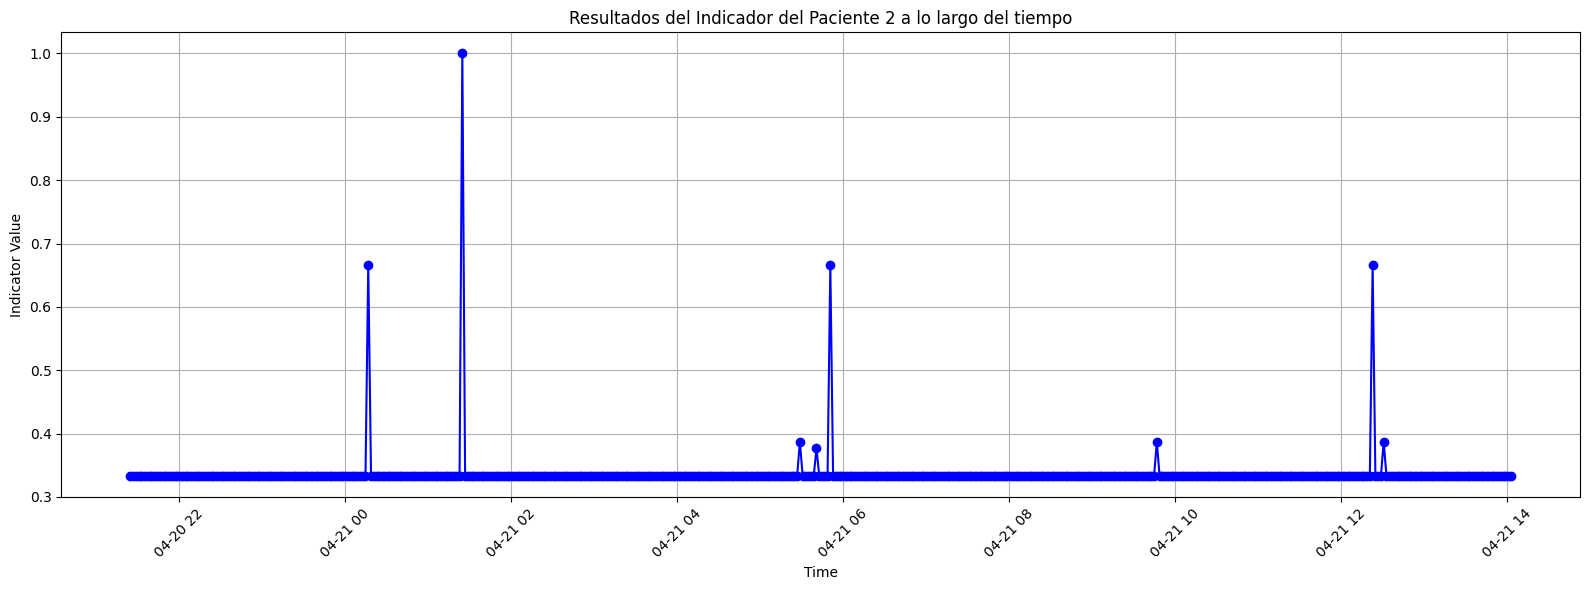

In [32]:
# calculate the indicator value for each pair of signals in each time window
results_combined = calculate_indicator_value(results_combined)

# Print the indicator values for each pair of signals in each time window.
print("Indicator values for each pair of signals in each time window:")
print(results_combined[['Start Time', 'End Time', 'Pair', 'Indicator Value']])

# CALCULATE THE PATIENT_INDICATOR AS THE SUM OF THE INDICATOR VALUES FOR EACH PAIR OF SIGNALS IN EACH TIME WINDOW, divided by the number of pairs of signals
def calculate_patient_indicator(indicator_df):
    # Group by 'Start Time' and 'End Time' to sum the indicator values for each time window.
    patient_indicator = indicator_df.groupby(['Start Time', 'End Time'], as_index=False).sum()
    
    # add one to the indicator value to avoid division by zero.
    patient_indicator['Indicator Value'] = patient_indicator['Indicator Value'] + 1
    
    # Calculate the number of pairs of signals in each time window.
    patient_indicator['Num Pairs'] = indicator_df.groupby(['Start Time', 'End Time'])['Pair'].nunique().values
    
    # Calculate the patient indicator as the sum of the indicator values divided by the number of pairs.
    patient_indicator['Indicator Value'] = patient_indicator['Indicator Value'] / patient_indicator['Num Pairs']
    return patient_indicator

# Calculate the patient indicator as the sum of the indicator values for each pair of signals in each time window.
patient_indicator = calculate_patient_indicator(results_combined)
# Print the patient indicator.
print("Patient indicator as the sum of the indicator values for each pair of signals in each time window:")
print(patient_indicator)

# plot the patient indicator over time
def plot_patient_indicator(patient_indicator):
    plt.figure(figsize=(16, 6))
    plt.plot(patient_indicator['Start Time'], patient_indicator['Indicator Value'], marker='o', linestyle='-', color='blue')
    plt.title('Resultados del Indicador del Paciente ' + str(id_paciente) + ' a lo largo del tiempo')
    plt.xlabel('Time')
    plt.ylabel('Indicator Value')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
# Plot the patient indicator over time.
plot_patient_indicator(patient_indicator)

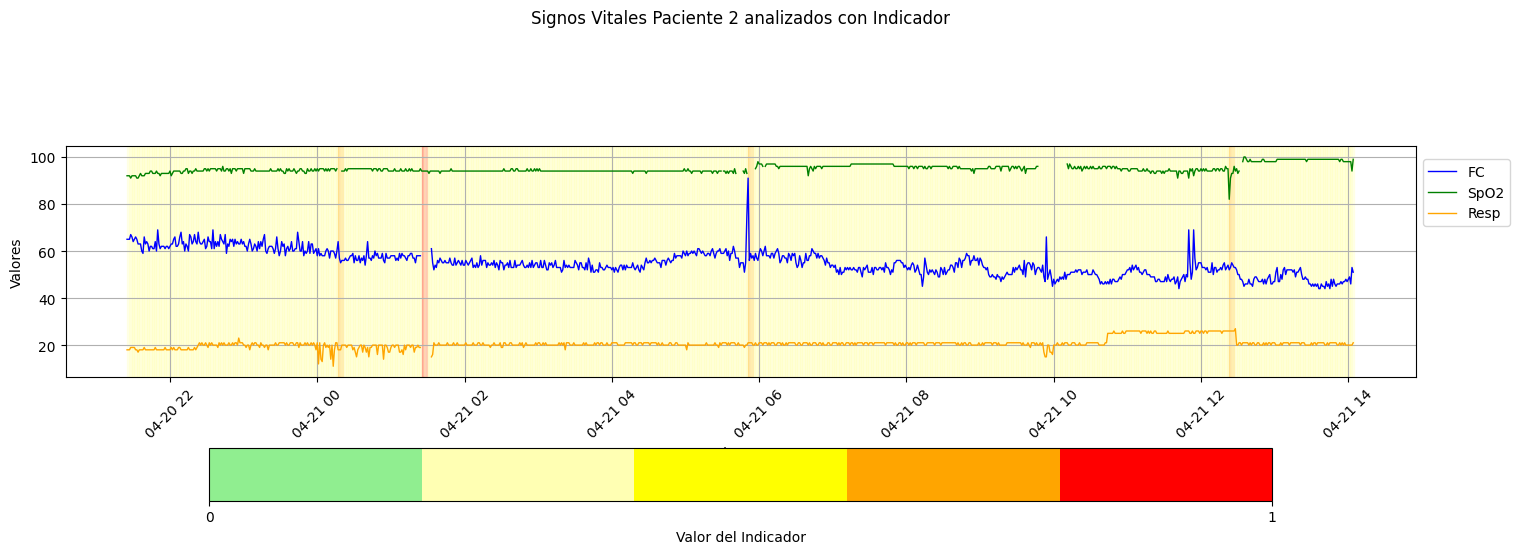

In [33]:
# graph the indicator over the patient's vital signs with a background color according to the indicator value.

def plot_indicator_with_vitals(patient_data, patient_id, patient_indicator):
    # Count anomalies for each row of patient data
    patient_data['Anomalies'] = patient_data.apply(count_anomalies, axis=1)
    
    # Define a dynamic color mapping based on the indicator value
    max_indicator_value = patient_indicator['Indicator Value'].max()
    colors = ['lightgreen', '#ffffB3', 'yellow', 'orange', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", colors, N=5)
    norm = mcolors.Normalize(vmin=0, vmax=max_indicator_value)
    
    # Create a color mapping for the indicator values
    color_values = patient_indicator['Indicator Value'].apply(lambda x: cmap(norm(x)))
    
    # Create a color mapping for the number of anomalies
    patient_data['color'] = patient_data['Anomalies'].apply(lambda x: cmap(norm(x)))
    # Create the base plot
    plt.figure(figsize=(18, 6))
    # Plot all vital signs dynamically
    for col in studied_vital_signs:
        plt.plot(patient_data.index, patient_data[col], label=col, linewidth=1, color=vital_sign_colors[col])
    plt.title(f'Signos Vitales Paciente {patient_id} analizados con Indicador', y=1.5)
    plt.xlabel('Tiempo')
    plt.ylabel('Valores')
    plt.xticks(rotation=45)
    plt.grid(True)
    # Add a color bar for the number of anomalies
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=plt.gca(), orientation='horizontal', pad=0.2, ticks=range(5), label='Valor del Indicador')
    # Apply background coloring based on the indicator value
    for i in range(len(patient_indicator.index) - 1):
        plt.axvspan(patient_indicator['Start Time'].iloc[i], patient_indicator['End Time'].iloc[i + 1], 
                    color=color_values.iloc[i], alpha=0.25)
        
    # finish the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))  # Position legend outside the plot area
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to leave space for the legend and raised title
    plt.show()
    
    
# use the function to plot the indicator with the patient's vital signs
plot_indicator_with_vitals(paciente0, str(id_paciente), patient_indicator)

### 5.3. Calcular metricas como categorias

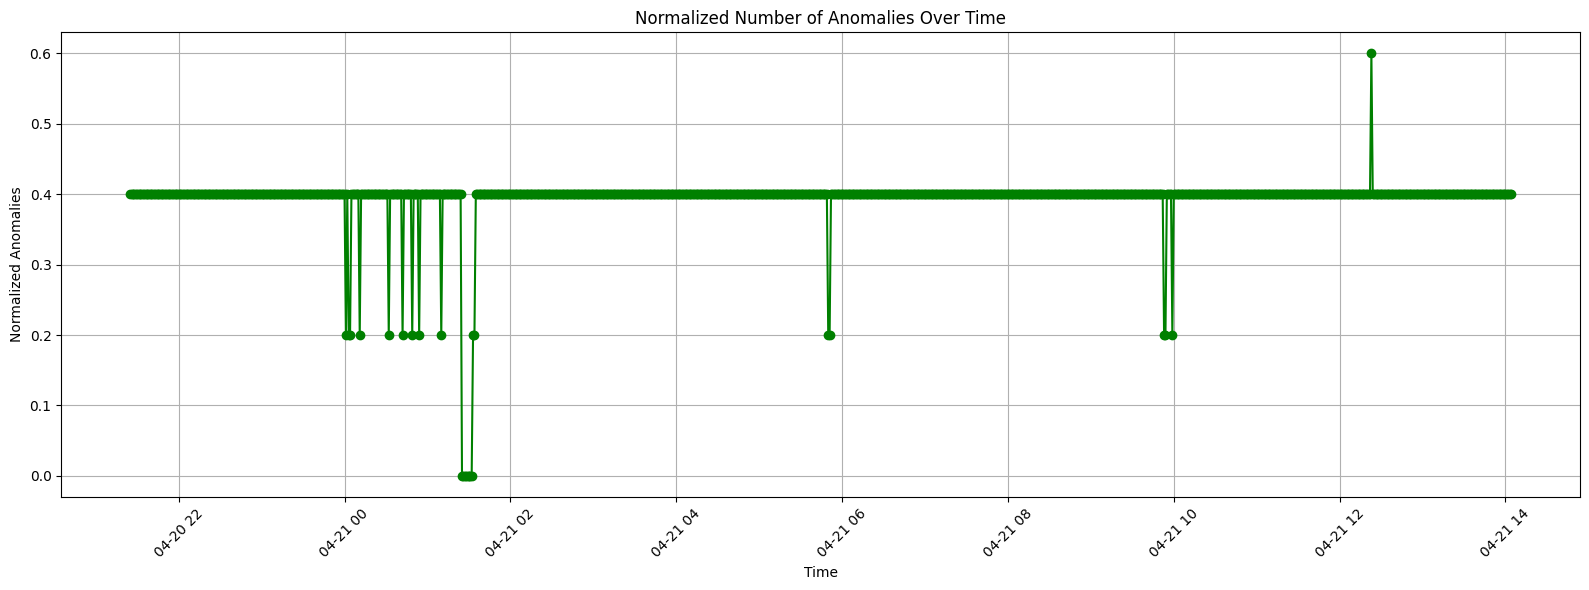

In [34]:
   
# calculate how the indicator compares to the number of vital signs outside the normal range.
# in order to obtain the accuracy and recall of the indicator.

# the number of signs outside the normal range is already calculated in the paciente0 DataFrame as 'Anomalies'.
# but we need to normalize this value over the number of vital signs.

def normalize_anomalies(patient_data):
    # Normalize the number of anomalies by the number of vital signs
    num_vital_signs = len(normal_ranges)

    
    patient_data['Normalized Anomalies'] = patient_data['Anomalies'] / num_vital_signs
    return patient_data

# Normalize the anomalies in the patient data
paciente0 = normalize_anomalies(paciente0)

def plot_normalized_anomalies(patient_data):
    plt.figure(figsize=(16, 6))
    # Use the index for the x-axis if 'Start Time' is the index
    plt.plot(patient_data.index, patient_data['Normalized Anomalies'], marker='o', linestyle='-', color='green')
    plt.title('Normalized Number of Anomalies Over Time')
    plt.xlabel('Time')
    plt.ylabel('Normalized Anomalies')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
# Plot the normalized anomalies over time.
plot_normalized_anomalies(paciente0)

In [35]:

# In order to calculate the accuracy and recall of the indicator, we'll create 3 discrete categories, indicating if the patient indicator is low, medium, or high.

# well calculate the same for the number of anomalies outside the normal range, so we can compare them. in a 3x3 matrix. and obtain the accuracy and recall of the indicator.


def categorize_indicator_and_anomalies(patient_data, patient_indicator):
    # Define thresholds for categorization
    low_threshold = 0.3
    high_threshold = 0.6
    
    
    # Categorize the normalized anomalies
    anomalies_category = []
    for index, row in patient_data.iterrows():
        if row['Normalized Anomalies'] < low_threshold:
            anomalies_category.append('Low')
        elif row['Normalized Anomalies'] < high_threshold:
            anomalies_category.append('Medium')
        else:
            anomalies_category.append('High')
    # Assign the categories to the DataFrame
    patient_data['True Category'] = anomalies_category
    
    # print the first 10 items of the anomalies category
    print("Anomalies Category (first 10 items):")
    print(patient_data['True Category'].head(10))
    
    # Categorize the patient indicator
    indicator_category = []
    for index, row in patient_indicator.iterrows():
        if row['Indicator Value'] < low_threshold:
            indicator_category.append('Low')
        elif row['Indicator Value'] < high_threshold:
            indicator_category.append('Medium')
        else:
            indicator_category.append('High')
    # Assign the categories to the patient indicator DataFrame
    patient_indicator['Indicator Category'] = indicator_category
    # print the first 10 items of the indicator category
    print("Indicator Category (first 10 items):")
    print(patient_indicator['Indicator Category'].head(10))
    
    # Get the results for normalized anomalies and put then in a new dataframe with numerical index
    min_len = min(len(patient_data), len(patient_indicator))

    # Truncate both DataFrames to the same length
    patient_data_trunc = patient_data.iloc[:min_len].reset_index(drop=True)
    patient_indicator_trunc = patient_indicator.iloc[:min_len].reset_index(drop=True)

    # Now create the results DataFrame using the truncated DataFrames
    results = pd.DataFrame({
        'Start Time': patient_indicator_trunc['Start Time'].values,
        'End Time': patient_indicator_trunc['End Time'].values,
        'True Category': patient_data_trunc['True Category'].values,
        'Indicator Category': patient_indicator_trunc['Indicator Category'].values,
        'Indicator Value': patient_indicator_trunc['Indicator Value'].values
    })
    # print the first 10 items of the results DataFrame
    print("Results DataFrame (first 10 items):")
    print(results.head(10))
    
    return results

# Categorize the indicator and anomalies
results = categorize_indicator_and_anomalies(paciente0, patient_indicator)

Anomalies Category (first 10 items):
Time
2025-04-20 21:25:00    Medium
2025-04-20 21:26:00    Medium
2025-04-20 21:27:00    Medium
2025-04-20 21:28:00    Medium
2025-04-20 21:29:00    Medium
2025-04-20 21:30:00    Medium
2025-04-20 21:31:00    Medium
2025-04-20 21:32:00    Medium
2025-04-20 21:33:00    Medium
2025-04-20 21:34:00    Medium
Name: True Category, dtype: object
Indicator Category (first 10 items):
0    Medium
1    Medium
2    Medium
3    Medium
4    Medium
5    Medium
6    Medium
7    Medium
8    Medium
9    Medium
Name: Indicator Category, dtype: object
Results DataFrame (first 10 items):
           Start Time            End Time True Category Indicator Category  \
0 2025-04-20 21:25:00 2025-04-20 21:27:00        Medium             Medium   
1 2025-04-20 21:27:00 2025-04-20 21:29:00        Medium             Medium   
2 2025-04-20 21:29:00 2025-04-20 21:31:00        Medium             Medium   
3 2025-04-20 21:31:00 2025-04-20 21:33:00        Medium             Medium   


In [36]:
# CALCULATE THE CONFUSION MATRIX FOR THE INDICATOR AND ANOMALIES
def calculate_confusion_matrix(results):
    # Create a confusion matrix
    confusion_matrix = pd.crosstab(results['True Category'], results['Indicator Category'], 
                                   rownames=['True'], colnames=['Predicted'], margins=True)
    return confusion_matrix
# Calculate the confusion matrix for the indicator and anomalies
confusion_matrix = calculate_confusion_matrix(results)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)

# Calculate the accuracy and recall for each category using sklearn's classification report
from sklearn.metrics import classification_report
def calculate_accuracy_recall(results):
    # Create a classification report
    report = classification_report(results['True Category'], results['Indicator Category'], output_dict=True)
    return report

# Calculate the accuracy and recall for the indicator
accuracy_recall = calculate_accuracy_recall(results)
# Print the accuracy and recall for the indicator
# print("Accuracy and Recall Report:")
# print(pd.DataFrame(accuracy_recall).transpose())

# extract the precision and recall from the weighted average
precision = accuracy_recall['weighted avg']['precision']
recall = accuracy_recall['weighted avg']['recall']
print()
# Print the precision and recall for the indicator
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

# calculate the F1 and F2 scores for the indicator
from sklearn.metrics import f1_score, fbeta_score
def calculate_f_scores(results, beta=2):
    # Calculate F1 and F2 scores
    f1 = f1_score(results['True Category'], results['Indicator Category'], average='weighted')
    f2 = fbeta_score(results['True Category'], results['Indicator Category'], beta=beta, average='weighted')
    return f1, f2
# Calculate the F1 and F2 scores for the indicator
f1, f2 = calculate_f_scores(results, beta=2)
# Print the F1 and F2 scores for the indicator
print(f"F1 Score: {f1:.2f}, F2 Score: {f2:.2f}")



Confusion Matrix:
Predicted  High  Medium  All
True                        
Low           0      19   19
Medium        4     477  481
All           4     496  500

Precision: 0.93, Recall: 0.95
F1 Score: 0.94, F2 Score: 0.95


/app/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/app/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/app/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/app/.venv/lib/python3.13/site-packages/sklearn/metrics/_

In [37]:
# do the exact same calculation for the anomaly level in results1
# it stores the anomaly level for each pair of signals in each time window. in results1['Anomaly Level'].

def normalize_original_anomalies(results1):

    # normalize by the number of signals
    num_vital_signs = len(normal_ranges)
    
    # Normalize the anomaly level by the number of pairs
    results1['Normalized Anomaly Level'] = results1['Anomaly Level'] / num_vital_signs
    return results1

results1 = normalize_original_anomalies(results1)

# Categorize the anomaly level in results1
def categorize_original_anomalies(patient_data, results1):
    # Define thresholds for categorization
    low_threshold = 0.3
    high_threshold = 0.6
    
    # Categorize the normalized anomaly level
    anomaly_category = []
    for index, row in results1.iterrows():
        if row['Normalized Anomaly Level'] < low_threshold:
            anomaly_category.append('Low')
        elif row['Normalized Anomaly Level'] < high_threshold:
            anomaly_category.append('Medium')
        else:
            anomaly_category.append('High')
    
    # Assign the categories to the DataFrame
    results1['Anomaly Category'] = anomaly_category
    # print the first 10 items of the anomaly category
    print("Anomaly Category (first 10 items):")
    print(results1['Anomaly Category'].head(10))
    # Get the results for normalized anomalies and put then in a new dataframe with numerical index
    # Truncate both DataFrames to the same length if needed
    min_len = min(len(patient_data), len(results1))

    patient_data_trunc = patient_data.iloc[:min_len].reset_index(drop=True)
    results1_trunc = results1.iloc[:min_len].reset_index(drop=True)

    results = pd.DataFrame({
        'Start Time': results1_trunc['Start Time'].values,
        'End Time': results1_trunc['End Time'].values,
        'True Category': patient_data_trunc['True Category'].values,
        'Anomaly Category': results1_trunc['Anomaly Category'].values
    })
    # print the first 10 items of the results DataFrame
    print("Results DataFrame (first 10 items):")
    print(results.head(10))
    return results

# Categorize the anomaly level in results1
new_results = categorize_original_anomalies(paciente0, results1)
# Calculate the confusion matrix for the anomaly level in results1


def calculate_confusion_matrix1(results1):
    # Create a confusion matrix for the anomaly level
    confusion_matrix1 = pd.crosstab(results1['True Category'], results1['Anomaly Category'], 
                                     rownames=['True'], colnames=['Predicted'], margins=True)
    return confusion_matrix1


confusion_matrix1 = calculate_confusion_matrix1(new_results)
# Print the confusion matrix for the anomaly level in results1
print("Confusion Matrix for Anomaly Level:")
print(confusion_matrix1)

def calculate_accuracy_recall1(results1):
    # Create a classification report for the anomaly level
    report1 = classification_report(results1['True Category'], results1['Anomaly Category'], output_dict=True)
    return report1
# Calculate the accuracy and recall for the anomaly level in results1
accuracy_recall1 = calculate_accuracy_recall1(new_results)
# Print the accuracy and recall for the anomaly level in results1
# print("Accuracy and Recall Report for Anomaly Level:")
# print(pd.DataFrame(accuracy_recall1).transpose())
# extract the precision and recall from the weighted average for the anomaly level
precision1 = accuracy_recall1['weighted avg']['precision']
recall1 = accuracy_recall1['weighted avg']['recall']
print()

# Print the precision and recall for the anomaly level in results1
print(f"Precision for Anomaly Level: {precision1:.2f}, Recall for Anomaly Level: {recall1:.2f}")
def calculate_f_scores1(results1, beta=2):
    # Calculate F1 and F2 scores for the anomaly level
    f1 = f1_score(results1['True Category'], results1['Anomaly Category'], average='weighted')
    f2 = fbeta_score(results1['True Category'], results1['Anomaly Category'], beta=beta, average='weighted')
    return f1, f2
# Calculate the F1 and F2 scores for the anomaly level in results1
f1_1, f2_1 = calculate_f_scores1(new_results, beta=2)
# Print the F1 and F2 scores for the anomaly level in results1
print(f"F1 Score for Anomaly Level: {f1_1:.2f}, F2 Score for Anomaly Level: {f2_1:.2f}")
    

Anomaly Category (first 10 items):
0       Low
1       Low
2       Low
3       Low
4    Medium
5       Low
6       Low
7       Low
8       Low
9       Low
Name: Anomaly Category, dtype: object
Results DataFrame (first 10 items):
           Start Time            End Time True Category Anomaly Category
0 2025-04-20 21:25:00 2025-04-20 21:27:00        Medium              Low
1 2025-04-20 21:27:00 2025-04-20 21:29:00        Medium              Low
2 2025-04-20 21:29:00 2025-04-20 21:31:00        Medium              Low
3 2025-04-20 21:31:00 2025-04-20 21:33:00        Medium              Low
4 2025-04-20 21:33:00 2025-04-20 21:35:00        Medium           Medium
5 2025-04-20 21:35:00 2025-04-20 21:37:00        Medium              Low
6 2025-04-20 21:37:00 2025-04-20 21:39:00        Medium              Low
7 2025-04-20 21:39:00 2025-04-20 21:41:00        Medium              Low
8 2025-04-20 21:41:00 2025-04-20 21:43:00        Medium              Low
9 2025-04-20 21:43:00 2025-04-20 21:45:00

### 5.4. Calcular reducción en el numero de falsos positivos

In [38]:
# El numero de falsos positicos es el numero de anomalias reportadas por el modelo que no son anomalias reales, es decir, cuando el paciente esta en un rango normal pero el modelo reporta una anomalia.


# Calcular falsos positivos para el modelo original:
# the resuls for the original model are stored in results1
def calculate_false_positives(results1, patient_data):
    # Count the number of false positives
    # these are where the normalized anomaly level is greater than 0 (indicating an anomaly was predicted) but the patient data in anomaly_df['Anomaly'] is False (indicating no actual anomaly).
    # DO NOT USE THE  CATEGORY, USE THE NORMALIZED VALUE
    false_positives = results1[
        (results1['Normalized Anomaly Level'] > 0.1) &
        (anomaly_df['Anomaly'] == False)  # This means the patient is in a normal range.
    ]

    # This means the model predicted an anomaly (not 'Low') but all thecc vital signs are within normal ranges.
    return len(false_positives)

false_positives = calculate_false_positives(results1, paciente0)
print(f"False Positives for the original model: {false_positives}")

# Calcular falsos positivos para el modelo de busqueda en subespacios:
def calculate_false_positives_search(results, patient_data, patient_indicator):
    # Count the number of false positives
    false_positives = results[
        (results['Indicator Value'] > 0.1) &  # This means the indicator value is greater than 0, indicating an anomaly was predicted.
        (anomaly_df['Anomaly'] == False)  # This means the patient is in a normal range.
    ]
    return len(false_positives)

false_positives_search = calculate_false_positives_search(results, paciente0, patient_indicator)
print(f"False Positives for the new model: {false_positives_search}")





False Positives for the original model: 481
False Positives for the new model: 485


In [39]:
# Calcular la reducción de falsos positivos:
def calculate_false_positive_reduction(original_fp, search_fp):
    if original_fp == 0:
        return 0
    reduction = ((original_fp - search_fp) / original_fp) * 100
    return reduction

false_positive_reduction = calculate_false_positive_reduction(false_positives, false_positives_search)

print(f"El nuevo modelo de busqueda en subespacios ha reducido los falsos positivos en un {false_positive_reduction}% respecto al modelo original.")

El nuevo modelo de busqueda en subespacios ha reducido los falsos positivos en un -0.8316008316008316% respecto al modelo original.
